Data misfit in time-domain.

#### Notebook config

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

INFO:numexpr.utils._init_num_threads: NumExpr defaulting to 4 threads.
/home/kajetan/software/Kolumbo-FWI/fwipy/__init__.py


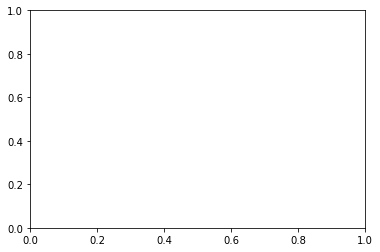

In [3]:
import fwipy 
print(fwipy.__file__)
from fwipy import *
from fwipy.config.logging import *
lll(40)
from fwipy.ioapi.segy import SgyFile

## Version 01

In [25]:
data_path = '../data/'
sgyobsm = SgyFile('data_kolumbo_PhD_all_traces_field_filtered_muted.sgy', data_path)
sgy000m = SgyFile('data_kolumbo_PhD_all_traces_synth_it000_muted.sgy', data_path)
sgy020m = SgyFile('data_kolumbo_PhD_all_traces_synth_it020_muted.sgy', data_path)
sgy080m = SgyFile('data_kolumbo_PhD_all_traces_synth_it080_muted.sgy', data_path)
sgy160m = SgyFile('data_kolumbo_PhD_all_traces_synth_it160_muted.sgy', data_path)

In [26]:
def get_bounds(srcs_x, srcs_y, recs_x, recs_y, pad=1000):
    x1 = min(min(srcs_x), min(recs_x)) #- pad
    y1 = min(min(srcs_y), min(recs_y)) - pad
    x2 = max(max(srcs_x), max(recs_x)) #+ pad
    y2 = max(max(srcs_y), max(recs_y)) + pad
    return x1, x2, y1, y2
def get_sr_coords(h, tracf, ep):
    df = h.loc[h.ep==ep]
    srcs_x = df.sx
    srcs_y = df.sy
    df = h.loc[h.tracf==tracf]
    recs_x = df.gx.unique()
    recs_y = df.gy.unique()
    return srcs_x, srcs_y, recs_x, recs_y
def calc_offset3d(df):
    import pandas as pd
    pd.options.mode.chained_assignment = None  # default='warn'
    df['offset3d'] = np.sqrt((df['sx'] - df['gx'])**2 +
                             (df['sy'] - df['gy'])**2 +
                             (df['selev'] + df['gelev'])**2)
    return df['offset3d']
def read_data_and_header(sgy1, sgy2, tracf, ep):
    from fwipy.ndat.arrays import Arr2d, modify_array, interleave_arrays
    # Read and normalise seismic data
    a1 = modify_array(sgy1.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0)[:,0,:], norm='rms')
    a2 = modify_array(sgy2.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0)[:,0,:], norm='rms')
    # Read metadata from SEGY header
    h = sgy1.read_header(overwrite=0)
    h = h.loc[(h.tracf==tracf) & (h.ep==ep)]
    calc_offset3d(h)
    return a1, a2, h
def compare_wiggles_acq(sgy1, sgy2, tracf, ep, dt=0.0025, A1=10, A2=10, k_lvz=55,
                        vel_red = 5000, # reduction velocity (m/s), #geom_factor=8000,
                        tmin=None, tmax=None,figsize=(10,5),
                        lw = 1, l1='field', l2=None, c_line1 = 'r', c_line2='k'):
    a1, a2, h = read_data_and_header(sgy1, sgy2, tracf, ep)
    ntr, ns = a1.shape
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(211)
    zero_vel = 1e-3
    for i, (x, offset3d) in enumerate(zip(h.sx, h.offset3d)):
        if abs(vel_red) > zero_vel:
            t = np.arange(0, ns) * dt - offset3d / vel_red
        else:
            t = np.arange(0, ns) * dt
        ax.plot(x + a1[i] * A1, t, color=c_line1, lw=lw, label=l1)
        ax.plot(x + a2[i] * A2, t, color=c_line2, lw=lw, label=l2)
    ax.set_xlim(min(h.sx), max(h.sx))
    ax.invert_yaxis()    
    plt.xlabel('X (m)')
    if abs(vel_red) > zero_vel:
        plt.ylabel('Reduced time (s) for vel_r= %s m/s' % vel_red)
    else:
        plt.ylabel('Time (s)')
    ax2 = ax.twiny()
    x1, x2 = ax.get_xbound()
    ax2.set_xbound(x1,x2)
    every = 20
    xticks = h.sx.values[::every]
    xlabels = [int(i) for i in h.offset3d[::every]]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)
    ax2.set_xlabel("Offset 3D (m)")
    plt.ylim(tmax,tmin)
    
    axin = fig.add_subplot(212)
    vp.plot(z=k_lvz, cmap='twilight', vmin=3700, vmax=5000, title=None, cbar=0)
    shotsize, shotcolor = 2, 'r'
    srcs_x, srcs_y, recs_x, recs_y = get_sr_coords(h, tracf, ep)
    x1, x2, y1, y2 = get_bounds(srcs_x, srcs_y, recs_x, recs_y, pad=1000)    
    axin.plot(srcs_x, srcs_y, linestyle='', marker='.', label='shot',
             markersize=1, markerfacecolor=shotcolor, markeredgecolor=shotcolor)
    axin.plot(recs_x, recs_y, marker='o', linestyle='', markersize=shotsize*3, 
                   markeredgecolor='k', markeredgewidth=1, markerfacecolor='b')    
    shift = 100
    for x, y in zip(recs_x, recs_y):
        xytext = (x+shift, y+shift)
        axin.annotate(text=str(tracf), xy=(x,y), xytext=xytext, clip_on=True, fontsize=8,
                    #bbox={'facecolor': 'k', 'edgecolor': 'w', 'alpha': .5, }
                     )    
    axin.set_xlim(x1,x2)
    axin.set_ylim(y1, y2)
    #axin.set_xticks([])
    axin.set_yticks([])
    bt.plot(mode='contour', aspect='equal')    

In [27]:
from arrau.a2d import Arr2d
xp = PROTEUS()
xp.read_all()
b01 = Box3d(+8.0e3, +2.5e4 , -3.0e3, +1.5e4, 0, +4.0e3)
bt = Arr2d(xp.bt.extract(extent=b01.xy).arr, extent=np.array(b01.xy))
vp = Arr3d(source='../data/p14-CP00160-Vp.mmp', shape=(341,361,81), extent=b01.extent)

In [44]:
kws = dict(tracf=4139, ep=31, vel_red=5000, tmin=1, tmax=2.6,  figsize=(14,22), k_lvz=55,
           A1=30, A2=30)

In [4]:
# compare_wiggles_acq(sgyobsm, sgy000m, **kws)
# compare_wiggles_acq(sgyobsm, sgy160m, **kws)

## Version 02

In [46]:
data_path = '../data/'
sgyobs = SgyFile('data_kolumbo_PhD_all_traces_field_fltrd.sgy', data_path)
sgy000 = SgyFile('data_kolumbo_PhD_all_traces_synth_it000.sgy', data_path)
sgy020 = SgyFile('data_kolumbo_PhD_all_traces_synth_it020.sgy', data_path)
sgy080 = SgyFile('data_kolumbo_PhD_all_traces_synth_it080.sgy', data_path)
sgy160 = SgyFile('data_kolumbo_PhD_all_traces_synth_it160.sgy', data_path)

In [57]:
data_path = '../data/'
sgyobsm = SgyFile('data_kolumbo_PhD_all_traces_field_fltrd_muted.sgy', data_path)
sgy000m = SgyFile('data_kolumbo_PhD_all_traces_synth_it000_muted.sgy', data_path)
sgy020m = SgyFile('data_kolumbo_PhD_all_traces_synth_it020_muted.sgy', data_path)
sgy080m = SgyFile('data_kolumbo_PhD_all_traces_synth_it080_muted.sgy', data_path)
sgy160m = SgyFile('data_kolumbo_PhD_all_traces_synth_it160_muted.sgy', data_path)

In [26]:
def get_bounds(srcs_x, srcs_y, recs_x, recs_y, pad=1000):
    x1 = min(min(srcs_x), min(recs_x)) #- pad
    y1 = min(min(srcs_y), min(recs_y)) - pad
    x2 = max(max(srcs_x), max(recs_x)) #+ pad
    y2 = max(max(srcs_y), max(recs_y)) + pad
    return x1, x2, y1, y2
def get_sr_coords(h, tracf, ep):
    df = h.loc[h.ep==ep]
    srcs_x = df.sx
    srcs_y = df.sy
    df = h.loc[h.tracf==tracf]
    recs_x = df.gx.unique()
    recs_y = df.gy.unique()
    return srcs_x, srcs_y, recs_x, recs_y
def calc_offset3d(df):
    import pandas as pd
    pd.options.mode.chained_assignment = None  # default='warn'
    df['offset3d'] = np.sqrt((df['sx'] - df['gx'])**2 +
                             (df['sy'] - df['gy'])**2 +
                             (df['selev'] + df['gelev'])**2)
    return df['offset3d']
def read_data_and_header(sgy1, sgy2, tracf, ep):
    from fwipy.ndat.arrays import Arr2d, modify_array, interleave_arrays
    # Read and normalise seismic data
    a1 = modify_array(sgy1.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0)[:,0,:], norm='rms')
    a2 = modify_array(sgy2.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0)[:,0,:], norm='rms')
    # Read metadata from SEGY header
    h = sgy1.read_header(overwrite=0)
    h = h.loc[(h.tracf==tracf) & (h.ep==ep)]
    calc_offset3d(h)
    return a1, a2, h
def compare_wiggles_acq(sgy1, sgy2, tracf, ep, dt=0.0025, A1=10, A2=10, k_lvz=55,
                        vel_red = 5000, # reduction velocity (m/s), #geom_factor=8000,
                        tmin=None, tmax=None,figsize=(10,5),
                        lw = 1, l1='field', l2=None, c_line1 = 'r', c_line2='k'):
    a1, a2, h = read_data_and_header(sgy1, sgy2, tracf, ep)
    ntr, ns = a1.shape
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(211)
    zero_vel = 1e-3
    for i, (x, offset3d) in enumerate(zip(h.sx, h.offset3d)):
        if abs(vel_red) > zero_vel:
            t = np.arange(0, ns) * dt - offset3d / vel_red
        else:
            t = np.arange(0, ns) * dt
        ax.plot(x + a1[i] * A1, t, color=c_line1, lw=lw, label=l1)
        ax.plot(x + a2[i] * A2, t, color=c_line2, lw=lw, label=l2)
    ax.set_xlim(min(h.sx), max(h.sx))
    ax.invert_yaxis()    
    plt.xlabel('X (m)')
    if abs(vel_red) > zero_vel:
        plt.ylabel('Reduced time (s) for vel_r= %s m/s' % vel_red)
    else:
        plt.ylabel('Time (s)')
    ax2 = ax.twiny()
    x1, x2 = ax.get_xbound()
    ax2.set_xbound(x1,x2)
    every = 20
    xticks = h.sx.values[::every]
    xlabels = [int(i) for i in h.offset3d[::every]]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)
    ax2.set_xlabel("Offset 3D (m)")
    plt.ylim(tmax,tmin)
    
    axin = fig.add_subplot(212)
    vp.plot(z=k_lvz, cmap='twilight', vmin=3700, vmax=5000, title=None, cbar=0)
    shotsize, shotcolor = 2, 'r'
    srcs_x, srcs_y, recs_x, recs_y = get_sr_coords(h, tracf, ep)
    x1, x2, y1, y2 = get_bounds(srcs_x, srcs_y, recs_x, recs_y, pad=1000)    
    axin.plot(srcs_x, srcs_y, linestyle='', marker='.', label='shot',
             markersize=1, markerfacecolor=shotcolor, markeredgecolor=shotcolor)
    axin.plot(recs_x, recs_y, marker='o', linestyle='', markersize=shotsize*3, 
                   markeredgecolor='k', markeredgewidth=1, markerfacecolor='b')    
    shift = 100
    for x, y in zip(recs_x, recs_y):
        xytext = (x+shift, y+shift)
        axin.annotate(text=str(tracf), xy=(x,y), xytext=xytext, clip_on=True, fontsize=8,
                    #bbox={'facecolor': 'k', 'edgecolor': 'w', 'alpha': .5, }
                     )    
    axin.set_xlim(x1,x2)
    axin.set_ylim(y1, y2)
    #axin.set_xticks([])
    axin.set_yticks([])
    bt.plot(mode='contour', aspect='equal')    

In [27]:
from arrau.a2d import Arr2d
xp = PROTEUS()
xp.read_all()
b01 = Box3d(+8.0e3, +2.5e4 , -3.0e3, +1.5e4, 0, +4.0e3)
bt = Arr2d(xp.bt.extract(extent=b01.xy).arr, extent=np.array(b01.xy))
vp = Arr3d(source='../data/p14-CP00160-Vp.mmp', shape=(341,361,81), extent=b01.extent)

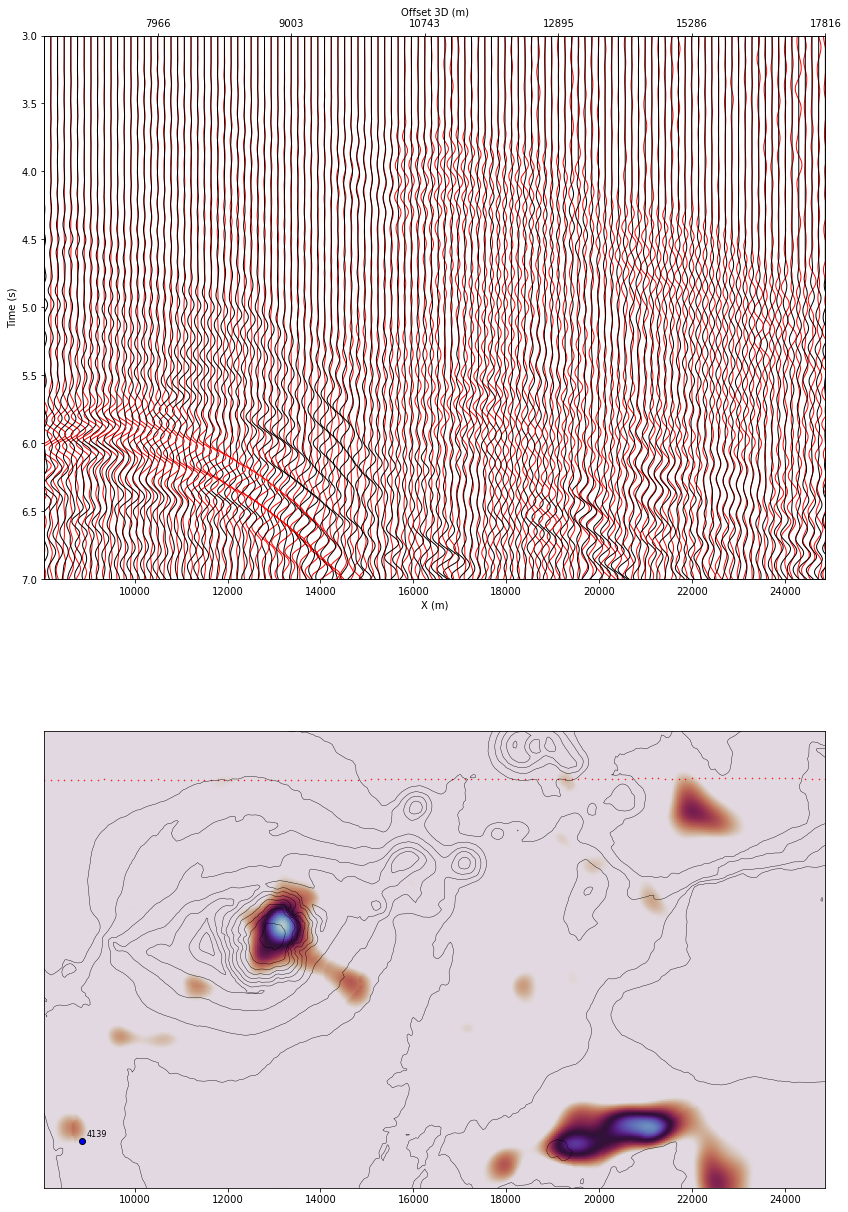

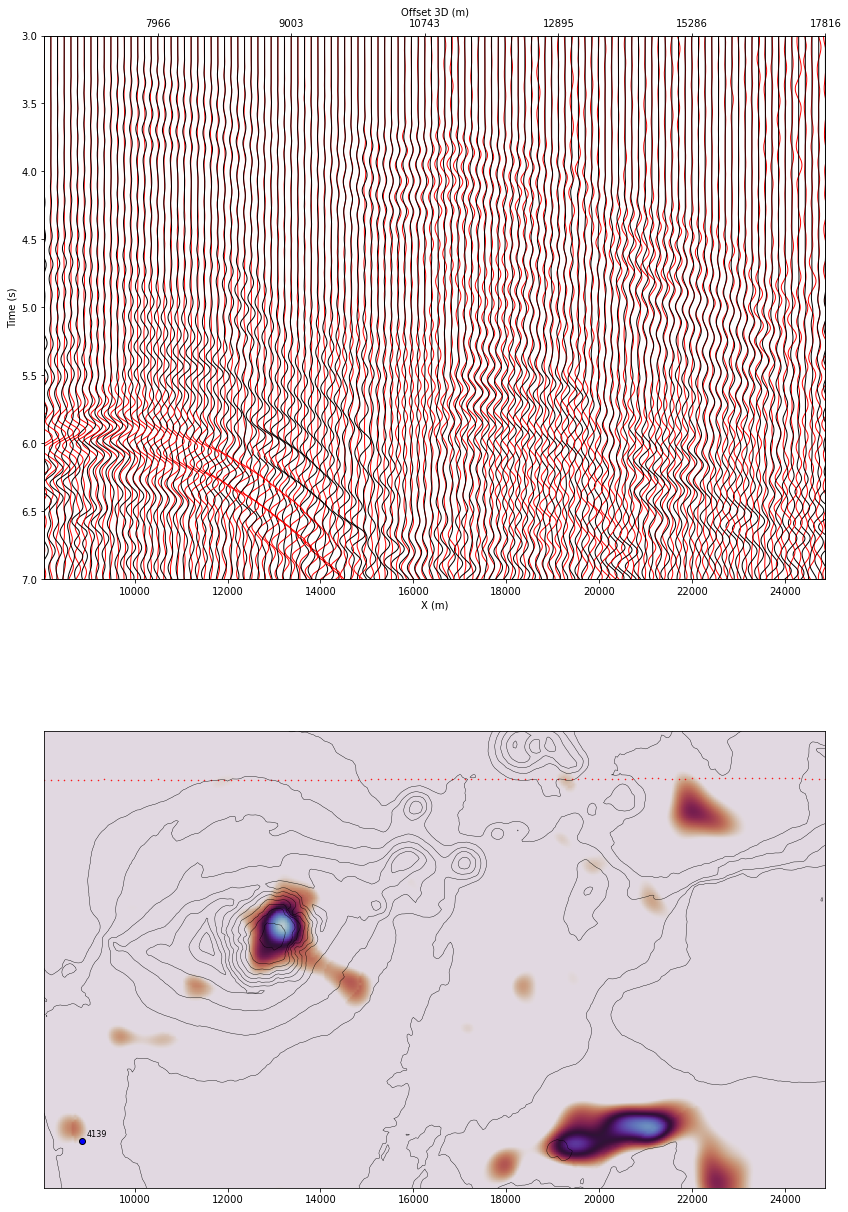

In [56]:
kws = dict(tracf=4139, ep=31, vel_red=0, tmin=3, tmax=7,  figsize=(14,22), k_lvz=55,
           A1=30, A2=30)
compare_wiggles_acq(sgyobs, sgy000, **kws)
compare_wiggles_acq(sgyobs, sgy160, **kws)

## Version 03

In [16]:
data_path = '../data/'
sgyobsm = SgyFile('data_kolumbo_PhD_all_traces_field_fltrd_muted.sgy', data_path)
sgy000m = SgyFile('data_kolumbo_PhD_all_traces_synth_it000_muted.sgy', data_path)
# sgy020m = SgyFile('data_kolumbo_PhD_all_traces_synth_it020_muted.sgy', data_path)
# sgy080m = SgyFile('data_kolumbo_PhD_all_traces_synth_it080_muted.sgy', data_path)
sgy160m = SgyFile('data_kolumbo_PhD_all_traces_synth_it160_muted.sgy', data_path)

In [27]:
from arrau.a2d import Arr2d
xp = PROTEUS()
xp.read_all()
b01 = Box3d(+8.0e3, +2.5e4 , -3.0e3, +1.5e4, 0, +4.0e3)
bt = Arr2d(xp.bt.extract(extent=b01.xy).arr, extent=np.array(b01.xy))
vp = Arr3d(source='../data/p14-CP00160-Vp.mmp', shape=(341,361,81), extent=b01.extent)

In [28]:
def get_bounds(srcs_x, srcs_y, recs_x, recs_y, pad=1000):
    x1 = min(min(srcs_x), min(recs_x)) #- pad
    y1 = min(min(srcs_y), min(recs_y)) - pad
    x2 = max(max(srcs_x), max(recs_x)) #+ pad
    y2 = max(max(srcs_y), max(recs_y)) + pad
    return x1, x2, y1, y2
def get_sr_coords(h, tracf, ep):
    df = h.loc[h.ep==ep]
    srcs_x = df.sx
    srcs_y = df.sy
    df = h.loc[h.tracf==tracf]
    recs_x = df.gx.unique()
    recs_y = df.gy.unique()
    return srcs_x, srcs_y, recs_x, recs_y
def calc_offset3d(df):
    import pandas as pd
    pd.options.mode.chained_assignment = None  # default='warn'
    df['offset3d'] = np.sqrt((df['sx'] - df['gx'])**2 +
                             (df['sy'] - df['gy'])**2 +
                             (df['selev'] + df['gelev'])**2)
    return df['offset3d']
def read_data_and_header(sgy1, sgy2, tracf, ep, norm='rms'):
    from fwipy.ndat.arrays import Arr2d, modify_array, interleave_arrays
    # Read and normalise seismic data
    a1 = modify_array(sgy1.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0)[:,0,:], norm=norm)
    a2 = modify_array(sgy2.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0)[:,0,:], norm=norm)
    # Read metadata from SEGY header
    h = sgy1.read_header(overwrite=0)
    h = h.loc[(h.tracf==tracf) & (h.ep==ep)]
    calc_offset3d(h)
    return a1, a2, h
def compare_wiggles(sgy1, sgy2, tracf, ep, it, dt=0.0025, A1=10, A2=10, k_lvz=55,
                    vel_red = 5000, # reduction velocity (m/s), #geom_factor=8000,
                    tmin=None, tmax=None,figsize=(10,5), norm='rms',
                    lw = 1, l1='field', l2='synthetic', c_line1 = 'r', c_line2='k',
                    save=False, plot_acq=False):
    a1, a2, h = read_data_and_header(sgy1, sgy2, tracf, ep, norm=norm)
    ntr, ns = a1.shape
    if plot_acq:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(211)
    else:
        fig, ax = plt.subplots(figsize=figsize)
    zero_vel = 1e-3
    for i, (x, offset3d) in enumerate(zip(h.sx, h.offset3d)):
        if abs(vel_red) > zero_vel:
            t = np.arange(0, ns) * dt - offset3d / vel_red
        else:
            t = np.arange(0, ns) * dt
        label1 = l1 if i == 0 else None
        label2 = l2 if i == 0 else None
        ax.plot(x + a1[i] * A1, t, color=c_line1, lw=lw, label=label1)
        ax.plot(x + a2[i] * A2, t, color=c_line2, lw=lw, label=label2)
    ax.set_xlim(min(h.sx), max(h.sx))
    ax.invert_yaxis()    
    plt.xlabel('X (m)')
    plt.ylabel('Reduced time (s)')
    plt.legend(loc='upper left')
    # Offset axis
    ax2 = ax.twiny()
    x1, x2 = ax.get_xbound()
    ax2.set_xbound(x1,x2)
    every = 20
    xticks = h.sx.values[::every]
    xlabels = [int(i) for i in h.offset3d[::every]]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)
    ax2.set_xlabel("Offset (m)")
    plt.ylim(tmax,tmin)

    if plot_acq:
        axin = fig.add_subplot(212)
        vp.plot(z=k_lvz, cmap='twilight', vmin=3700, vmax=5000, title=None, cbar=0)
        shotsize, shotcolor = 2, 'r'
        srcs_x, srcs_y, recs_x, recs_y = get_sr_coords(h, tracf, ep)
        x1, x2, y1, y2 = get_bounds(srcs_x, srcs_y, recs_x, recs_y, pad=1000)    
        axin.plot(srcs_x, srcs_y, linestyle='', marker='.', label='shot',
                 markersize=1, markerfacecolor=shotcolor, markeredgecolor=shotcolor)
        axin.plot(recs_x, recs_y, marker='o', linestyle='', markersize=shotsize*3, 
                       markeredgecolor='k', markeredgewidth=1, markerfacecolor='b')    
        shift = 100
        for x, y in zip(recs_x, recs_y):
            xytext = (x+shift, y+shift)
            axin.annotate(text=str(tracf), xy=(x,y), xytext=xytext, clip_on=True, fontsize=8,
                        #bbox={'facecolor': 'k', 'edgecolor': 'w', 'alpha': .5, }
                         )    
        axin.set_xlim(x1,x2)
        axin.set_ylim(y1, y2)
        #axin.set_xticks([])
        axin.set_yticks([])
        bt.plot(mode='contour', aspect='equal')    
    
    
    
    if save:
        plt.savefig('figures/fig02b_OBS%s_line%s_it%s.png' % (tracf, str(ep).rjust(3, '0'), str(it).rjust(3, '0')),
                    dpi=300)
        plt.close()
# plt.style.reload_library()
# plt.style.use(['default', 'paper2022kolumbo'])
for tracf in [4125, 4124, 4123, 4139, 4138, 4137]: #[4104, 4105, 4109, 4110, 4112]:
    for ep in [38, 5, 31, 37, 6]:# [30, 7, 27, 8, 26, 9]:
        kws = dict(tracf=tracf, ep=ep, save=1, plot_acq=0,
           vel_red=5000, tmin=1, tmax=2.6,  figsize=(12,4), k_lvz=55, A1=30, A2=30)
        compare_wiggles(sgyobsm, sgy000m, it=0, **kws)
        compare_wiggles(sgyobsm, sgy160m, it=160, **kws)

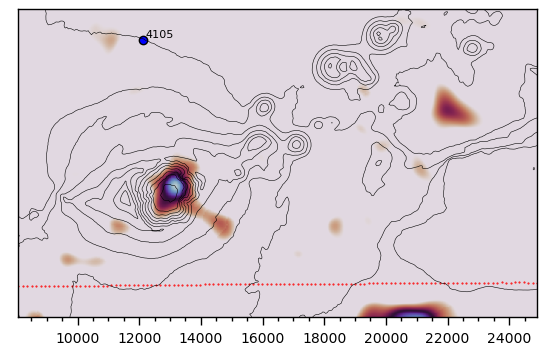

In [153]:
def plot_model(sgy1, sgy2, tracf, ep, it, dt=0.0025, A1=10, A2=10, k_lvz=55,
                    vel_red = 5000, # reduction velocity (m/s), #geom_factor=8000,
                    tmin=None, tmax=None,figsize=(10,5), norm='rms',
                    lw = 1, l1='field', l2='synthetic', c_line1 = 'r', c_line2='k',
                    save=False, plot_acq=False):       
    fig, axin = plt.subplots(figsize=figsize)
    a1, a2, h = read_data_and_header(sgy1, sgy2, tracf, ep, norm=norm)

    vp.plot(z=k_lvz, cmap='twilight', vmin=3700, vmax=5000, title=None, cbar=0)
    shotsize, shotcolor = 2, 'r'
    srcs_x, srcs_y, recs_x, recs_y = get_sr_coords(h, tracf, ep)
    x1, x2, y1, y2 = get_bounds(srcs_x, srcs_y, recs_x, recs_y, pad=1000)    
    axin.plot(srcs_x, srcs_y, linestyle='', marker='.', label='shot',
             markersize=1, markerfacecolor=shotcolor, markeredgecolor=shotcolor)
    axin.plot(recs_x, recs_y, marker='o', linestyle='', markersize=shotsize*3, 
                   markeredgecolor='k', markeredgewidth=1, markerfacecolor='b')    
    shift = 100
    for x, y in zip(recs_x, recs_y):
        xytext = (x+shift, y+shift)
        axin.annotate(text=str(tracf), xy=(x,y), xytext=xytext, clip_on=True, fontsize=8,
                    #bbox={'facecolor': 'k', 'edgecolor': 'w', 'alpha': .5, }
                     )    
    axin.set_xlim(x1,x2)
    axin.set_ylim(y1, y2)
    #axin.set_xticks([])
    axin.set_yticks([])
    bt.plot(mode='contour', aspect='equal')    
plot_model(sgyobsm, sgy160m, it=160, **kws)

## Version 04

In [5]:
# read data before muting 
data_path = '../data/'
sgyobs = SgyFile('data_kolumbo_PhD_all_traces_field_fltrd.sgy', data_path)
sgy000 = SgyFile('data_kolumbo_PhD_all_traces_synth_it000.sgy', data_path)
# sgy020 = SgyFile('data_kolumbo_PhD_all_traces_synth_it020.sgy', data_path)
# sgy080 = SgyFile('data_kolumbo_PhD_all_traces_synth_it080.sgy', data_path)
sgy160 = SgyFile('data_kolumbo_PhD_all_traces_synth_it160.sgy', data_path)

In [60]:
# read data after muting
data_path = '../data/'
sgyobsm = SgyFile('data_kolumbo_PhD_all_traces_field_fltrd_muted.sgy', data_path)
sgy000m = SgyFile('data_kolumbo_PhD_all_traces_synth_it000_muted.sgy', data_path)
# sgy020m = SgyFile('data_kolumbo_PhD_all_traces_synth_it020_muted.sgy', data_path)
# sgy080m = SgyFile('data_kolumbo_PhD_all_traces_synth_it080_muted.sgy', data_path)
sgy160m = SgyFile('data_kolumbo_PhD_all_traces_synth_it160_muted.sgy', data_path)

In [32]:
# read bathymetry and final model 
from arrau.a2d import Arr2d
xp = PROTEUS()
xp.read_all()
b01 = Box3d(+8.0e3, +2.5e4 , -3.0e3, +1.5e4, 0, +4.0e3)
bt = Arr2d(xp.bt.extract(extent=b01.xy).arr, extent=np.array(b01.xy))
vp = Arr3d(source='../data/p14-CP00160-Vp.mmp', shape=(341,361,81), extent=b01.extent)

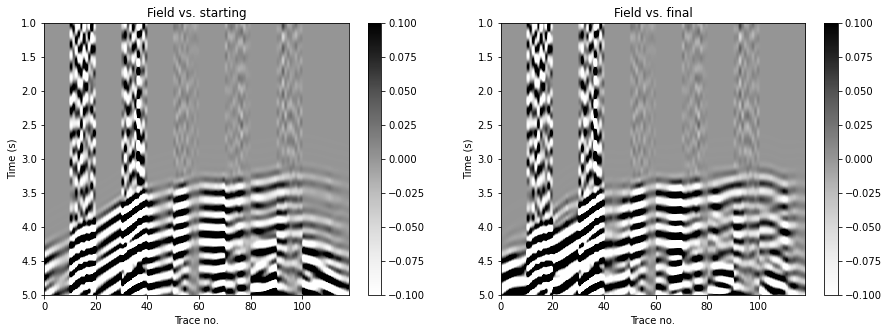

In [14]:
def compare_data(sgy1, sgy2, tracf, ep, dt=0.0025, cmap='Greys', tmin=None, tmax=None,
                vmin=None, vmax=None):
    from fwipy.ndat.arrays import Arr2d, modify_array, interleave_arrays
    a1 = modify_array(sgy1.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0)[:,0,:], norm='max')
    a2 = modify_array(sgy2.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0)[:,0,:], norm='max')
    t1 = 0
    t2 = a1.shape[-1] * dt
    x1 = 0
    x2 = a1.shape[0]
    a = interleave_arrays(a1, a2)
    plt.imshow(a.T, aspect='auto', extent=[x1, x2, t2, t1],
               cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.xlabel('Trace no.')
    plt.ylabel('Time (s)')
    plt.ylim(tmax, tmin)
vlim = .1
kws = dict(tracf=4105, ep=27, tmin=1, tmax=5, vmin=-vlim, vmax=vlim)
figure(15,5)
plt.subplot(121)
plt.title('Field vs. starting')
compare_data(sgy000, sgyobs, **kws)
plt.subplot(122)
plt.title('Field vs. final')
compare_data(sgy160, sgyobs, **kws)    

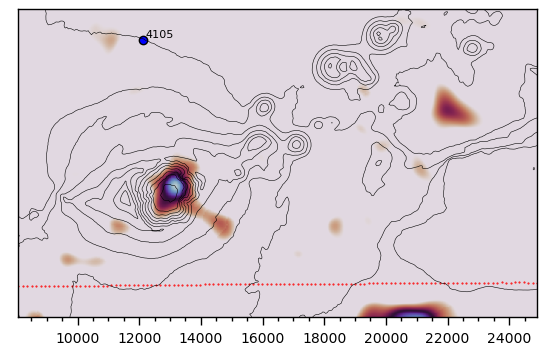

In [153]:
def plot_model(sgy1, sgy2, tracf, ep, it, dt=0.0025, A1=10, A2=10, k_lvz=55,
                    vel_red = 5000, # reduction velocity (m/s), #geom_factor=8000,
                    tmin=None, tmax=None,figsize=(10,5), norm='rms',
                    lw = 1, l1='field', l2='synthetic', c_line1 = 'r', c_line2='k',
                    save=False, plot_acq=False):       
    fig, axin = plt.subplots(figsize=figsize)
    a1, a2, h = read_data_and_header(sgy1, sgy2, tracf, ep, norm=norm)

    vp.plot(z=k_lvz, cmap='twilight', vmin=3700, vmax=5000, title=None, cbar=0)
    shotsize, shotcolor = 2, 'r'
    srcs_x, srcs_y, recs_x, recs_y = get_sr_coords(h, tracf, ep)
    x1, x2, y1, y2 = get_bounds(srcs_x, srcs_y, recs_x, recs_y, pad=1000)    
    axin.plot(srcs_x, srcs_y, linestyle='', marker='.', label='shot',
             markersize=1, markerfacecolor=shotcolor, markeredgecolor=shotcolor)
    axin.plot(recs_x, recs_y, marker='o', linestyle='', markersize=shotsize*3, 
                   markeredgecolor='k', markeredgewidth=1, markerfacecolor='b')    
    shift = 100
    for x, y in zip(recs_x, recs_y):
        xytext = (x+shift, y+shift)
        axin.annotate(text=str(tracf), xy=(x,y), xytext=xytext, clip_on=True, fontsize=8,
                    #bbox={'facecolor': 'k', 'edgecolor': 'w', 'alpha': .5, }
                     )    
    axin.set_xlim(x1,x2)
    axin.set_ylim(y1, y2)
    #axin.set_xticks([])
    axin.set_yticks([])
    bt.plot(mode='contour', aspect='equal')    
plot_model(sgyobsm, sgy160m, it=160, **kws)

In [70]:
import plotea

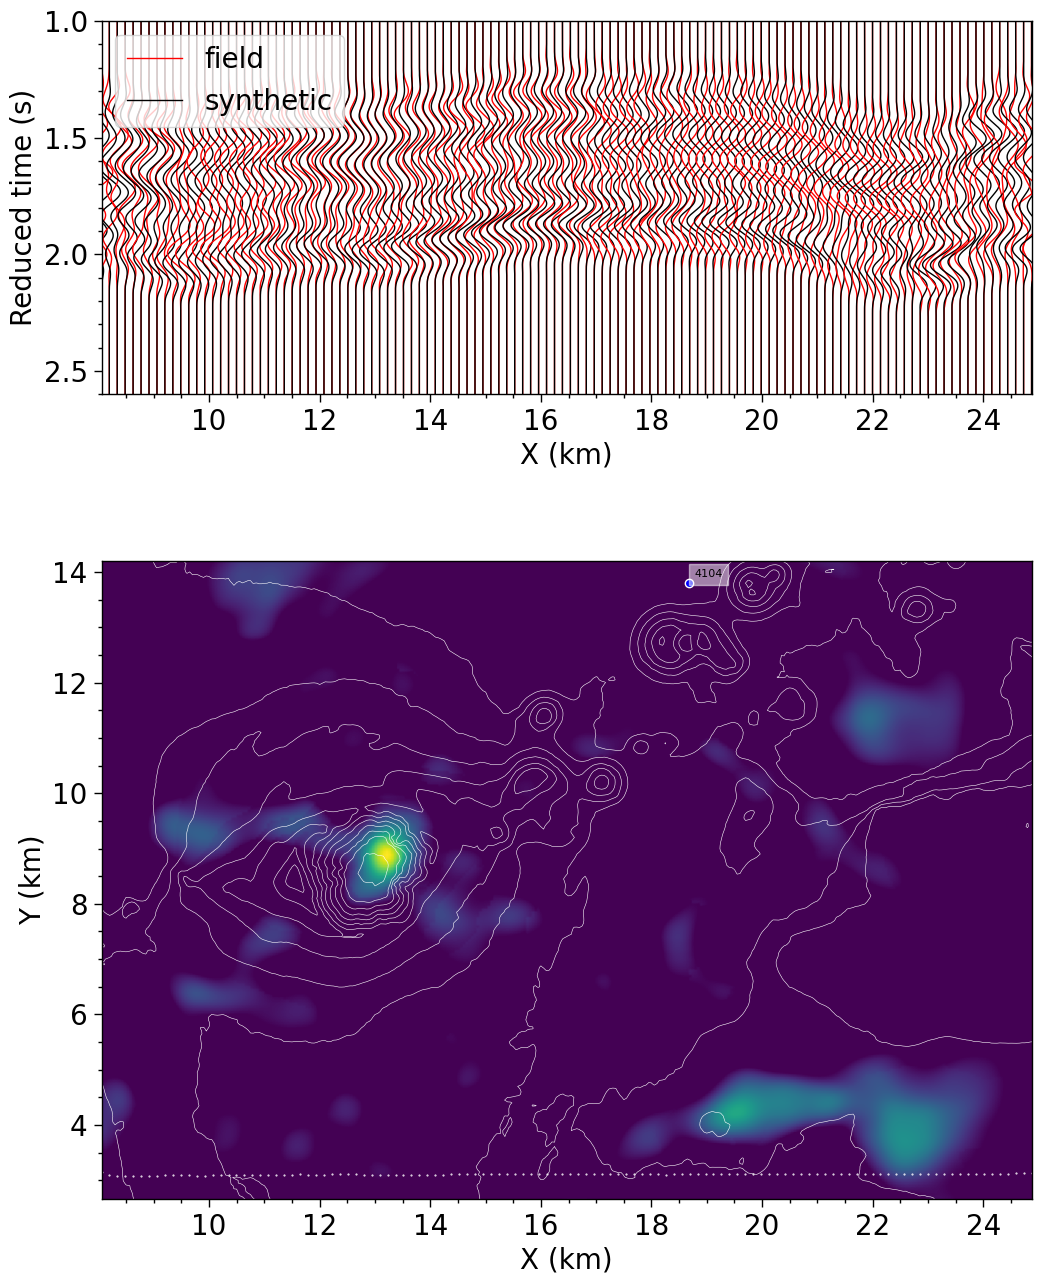

In [112]:
def get_bounds(srcs_x, srcs_y, recs_x, recs_y, pad=1000):
    x1 = min(min(srcs_x), min(recs_x)) #- pad
    y1 = min(min(srcs_y), min(recs_y)) - pad
    x2 = max(max(srcs_x), max(recs_x)) #+ pad
    y2 = max(max(srcs_y), max(recs_y)) + pad
    return x1, x2, y1, y2
def get_sr_coords(h, tracf, ep):
    df = h.loc[h.ep==ep]
    srcs_x = df.sx
    srcs_y = df.sy
    df = h.loc[h.tracf==tracf]
    recs_x = df.gx.unique()
    recs_y = df.gy.unique()
    return srcs_x, srcs_y, recs_x, recs_y
def calc_offset3d(df):
    import pandas as pd
    pd.options.mode.chained_assignment = None  # default='warn'
    df['offset3d'] = np.sqrt((df['sx'] - df['gx'])**2 +
                             (df['sy'] - df['gy'])**2 +
                             (df['selev'] + df['gelev'])**2)
    return df['offset3d']
def read_data_and_header(sgy1, sgy2, tracf, ep, norm='rms'):
    from fwipy.ndat.arrays import Arr2d, modify_array, interleave_arrays
    # Read and normalise seismic data
    a1 = modify_array(sgy1.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0)[:,0,:], norm=norm)
    a2 = modify_array(sgy2.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0)[:,0,:], norm=norm)
    # Read metadata from SEGY header
    h = sgy1.read_header(overwrite=0)
    h = h.loc[(h.tracf==tracf) & (h.ep==ep)]
    calc_offset3d(h)
    return a1, a2, h
def compare_wiggles(sgy1, sgy2, tracf, ep, it, dt=0.0025, A1=10, A2=10, k_lvz=55,
                    vel_red = 5000, # reduction velocity (m/s), #geom_factor=8000,
                    height_ratio=3,
                    tmin=None, tmax=None,figsize=(10,5), norm='rms',
                    lw = 1, l1='field', l2='synthetic', c_line1 = 'r', c_line2='k',
                    save=False, plot_acq=False):
    import matplotlib.ticker as ticker
    scale_y = 1e3
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
    
    a1, a2, h = read_data_and_header(sgy1, sgy2, tracf, ep, norm=norm)
    ntr, ns = a1.shape
    if plot_acq:
        from matplotlib.gridspec import GridSpec
        gs = GridSpec(2, 1, height_ratios=[1, height_ratio])
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(gs[0, 0])
    else:
        fig, ax = plt.subplots(figsize=figsize)
    zero_vel = 1e-3
    for i, (x, offset3d) in enumerate(zip(h.sx, h.offset3d)):
        if abs(vel_red) > zero_vel:
            t = np.arange(0, ns) * dt - offset3d / vel_red
        else:
            t = np.arange(0, ns) * dt
        label1 = l1 if i == 0 else None
        label2 = l2 if i == 0 else None
        ax.plot(x + a1[i] * A1, t, color=c_line1, lw=lw, label=label1)
        ax.plot(x + a2[i] * A2, t, color=c_line2, lw=lw, label=label2)
    ax.set_xlim(min(h.sx), max(h.sx))
    ax.xaxis.set_major_formatter(ticks_y)
    
    ax.invert_yaxis()    
    plt.xlabel('X (km)')
    plt.ylabel('Reduced time (s)')
    plt.legend(loc='upper left')
    # Offset axis
#     ax2 = ax.twiny()
#     x1, x2 = ax.get_xbound()
#     ax2.set_xbound(x1,x2)
#     every = 20
#     xticks = h.sx.values[::every]
#     xlabels = [int(i) for i in h.offset3d[::every]]
#     print(xlabels)
#     ax2.set_xticks(xticks)
#     ax2.set_xticklabels(xlabels)
#     ax2.set_xlabel("Offset (km)")
#     ax2.xaxis.set_major_formatter(ticks_y)
    plt.ylim(tmax,tmin)

    if plot_acq:
        axin = fig.add_subplot(gs[1, 0])
        vp.plot(z=k_lvz, cmap='viridis_r', vmin=3400, vmax=5000, title=None, cbar=0)
        shotsize, shotcolor = 3, 'w'
        srcs_x, srcs_y, recs_x, recs_y = get_sr_coords(h, tracf, ep)
        x1, x2, y1, y2 = get_bounds(srcs_x, srcs_y, recs_x, recs_y, pad=400)    
        axin.plot(srcs_x, srcs_y, linestyle='', marker='.', label='shot',
                 markersize=1, markerfacecolor=shotcolor, markeredgecolor=shotcolor)
        axin.plot(recs_x, recs_y, marker='o', linestyle='', markersize=shotsize*2, 
                       markeredgecolor='w', markeredgewidth=1, markerfacecolor='b')    
        shift = 100
        for x, y in zip(recs_x, recs_y):
            xytext = (x+shift, y+shift)
            axin.annotate(text=str(tracf), xy=(x,y), xytext=xytext, clip_on=True, fontsize=8,
                        bbox={'facecolor': 'w', 'edgecolor': 'w', 'alpha': .5, }
                         )   

        axin.set_xlim(x1,x2)
        axin.set_ylim(y1, y2)
        axin.xaxis.set_major_formatter(ticks_y)
        axin.yaxis.set_major_formatter(ticks_y)

        #axin.set_xticks([])
        #axin.set_yticks([])
        bt.plot(mode='contour', aspect='equal', colors='w')    
        axin.set_xlabel('X (km)')
        axin.set_ylabel('Y (km)')        
    if save: 
        add = '_acq'  if plot_acq else ''
        plt.savefig('figures/fig02b/fig02b%s_OBS%s_line%s_it%s.png' % (add, tracf, str(ep).rjust(3, '0'), str(it).rjust(3, '0')),
                    dpi=300)
        plt.close()
plt.style.reload_library()
plt.style.use(['default', 'paper2022kolumbo'])
plt.rcParams.update({'font.size': 20})
for tracf in [4104]: #[4104, 4105, 4109, 4110, 4112]:
    for ep in [26]:# [30, 7, 27, 8, 26, 9]:
        kws = dict(tracf=tracf, ep=ep, save=0, plot_acq=1, height_ratio=2,
           vel_red=5000, tmin=1, tmax=2.6,  figsize=(12,16), k_lvz=51, A1=30, A2=30)
        compare_wiggles(sgyobsm, sgy000m, it=0, **kws)
#         compare_wiggles(sgyobsm, sgy160m, it=160, **kws)

In [90]:
obs_above = [4104, 4105, 4109, 4110, 4112]
lines_below = [30, 7, 27, 8, 26, 9]

obs_below = [4125, 4124, 4123, 4139, 4138, 4137]
lines_above = [38, 5, 31, 37, 6, 30]

In [116]:
%%time
plt.style.reload_library()
plt.style.use(['default', 'paper2022kolumbo'])
plt.rcParams.update({'font.size': 20})
for tracf in obs_above: 
    for ep in lines_below:
# for tracf in obs_below:
#     for ep in lines_above:        
        kws = dict(tracf=tracf, ep=ep, save=1, plot_acq=1, height_ratio=2,
           vel_red=5000, tmin=1, tmax=2.6,  figsize=(12,16), k_lvz=51, A1=30, A2=30)
        compare_wiggles(sgyobsm, sgy000m, it=0, **kws)
        compare_wiggles(sgyobsm, sgy160m, it=160, **kws)

CPU times: user 4min 7s, sys: 23.7 s, total: 4min 31s
Wall time: 7min 59s


# ...